# Variational Quantum Classifier (VQC) Best Parameter Training

The notebook trains a VQC, based on best params found in grid search

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [1]:
# imports
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import clear_output

import os
import time

# import data class
from utilities.dataset_utils import DiabetesData

# import metrics for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# qiskit imports
# circuit transpiler
from qiskit import transpile

# algorithm
from qiskit_machine_learning.algorithms.classifiers import VQC

# feature map
from qiskit.circuit.library import z_feature_map

# ansatz
from qiskit.circuit.library import efficient_su2

# optimizer
from qiskit_machine_learning.optimizers import COBYLA

# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [2]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [3]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [4]:
# feature map
feature_map = z_feature_map(feature_dimension=dataset.get_num_features(), reps=2, entanglement='linear')
feature_map = transpile(feature_map, backend=backend, optimization_level=3) # transpile to backend

In [5]:
# ansatz
ansatz = efficient_su2(num_qubits=dataset.get_num_features(), reps=3, entanglement='linear')
ansatz = transpile(ansatz, backend=backend, optimization_level=3) # transpile to backend

In [6]:
# callback graph
# init list to store objective function values
objective_func_vals = []

# larger size for graph
plt.rcParams["figure.figsize"] = (12, 6)

# callback function to plot objective function value (updates after each iteration)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective Function Value")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(objective_func_vals)
    plt.show()

In [7]:
# optimizer
optimizer = COBYLA(maxiter=300)

In [8]:
# sampler
sampler = Sampler.from_backend(backend)

In [9]:
# create the VQC instance
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


### Model Fit on Simulator

In [10]:
# get training and testing data
X_train, X_test, y_train, y_test = dataset.preprocess_data()

In [11]:
sample_size = 200
# define smaller sample size for training
if len(X_train) > sample_size:
    X_train_sample = X_train[:sample_size]
    y_train_sample = y_train[:sample_size]
else:
    X_train_sample = X_train
    y_train_sample = y_train

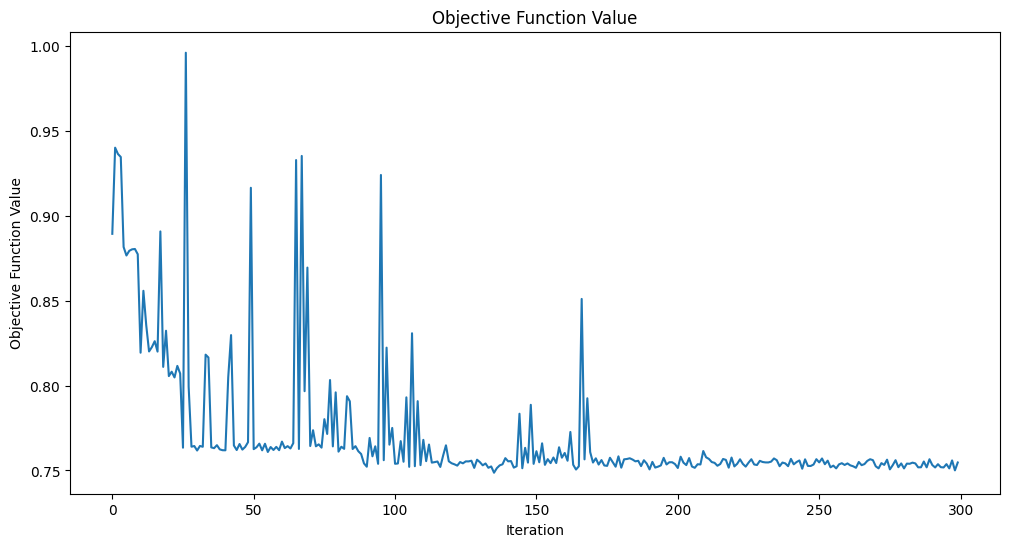

Training Time: 935 secs
[0.8894698771047281, 0.9402372593032983, 0.9365021240570769, 0.9347467642503781, 0.8816987827223854, 0.8767033241310722, 0.8794602610375263, 0.8803400043952164, 0.8805338216183968, 0.877455178209026, 0.819413066152344, 0.8558953084355518, 0.8356249360100225, 0.8201495955409571, 0.8227154803953111, 0.8261991412567132, 0.8200749731747823, 0.8908847754361314, 0.8110567207718857, 0.8323532194485186, 0.8056261624416079, 0.80822392916675, 0.8048439582971166, 0.8116385531948889, 0.8071335086232878, 0.763437914405134, 0.9961914237874848, 0.799448796741014, 0.7640194971344519, 0.7644197568724298, 0.7617837042539386, 0.7644734608555289, 0.7639703550488804, 0.8182670886334257, 0.8165796515911036, 0.763624524652456, 0.763157357550521, 0.7649222694415353, 0.7624494636967104, 0.761949215695759, 0.7619027439152648, 0.8049260207869723, 0.8297999886336068, 0.7647386410530795, 0.7620620482636704, 0.7656030431020898, 0.7623007942253981, 0.7638870600249081, 0.7666873146151727, 0.91

In [12]:
# time how long it takes to train
start = time.time()

# fit the model
vqc = vqc.fit(X_train, y_train)

end = time.time()
elapsed = end - start

# print training time
print(f"Training Time: {round(elapsed)} secs")

# print objective func val at each iteration
print(objective_func_vals)

### VQC Evaluation

In [13]:
# reset rcParams to default
plt.rcParams["figure.figsize"] = (6,4)

In [14]:
train_score = vqc.score(X_train_sample, y_train_sample)
test_score = vqc.score(X_test, y_test)
train_score, test_score

(0.765, 0.7402597402597403)

In [15]:
# predict
y_pred = vqc.predict(X_test)

In [16]:
# confusion matrix
def conf_matrix(y_test, y_pred):
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix: VQC')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [17]:
# accuracy score
accuracy = accuracy_score(y_test, y_pred)

In [18]:
# classification report
report = classification_report(y_test, y_pred, zero_division=0, output_dict=False)

Accuracy: 0.7359307359307359
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       150
           1       0.72      0.41      0.52        81

    accuracy                           0.74       231
   macro avg       0.73      0.66      0.67       231
weighted avg       0.73      0.74      0.71       231



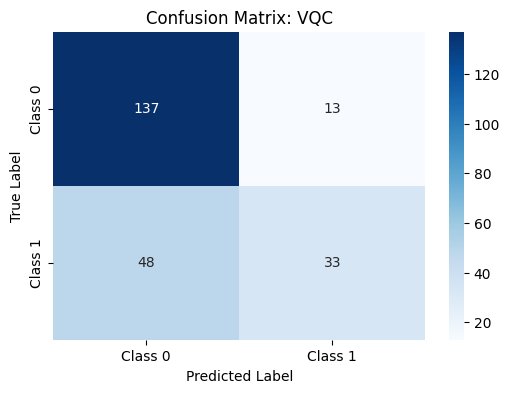

In [19]:
# print metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
conf_matrix(y_test, y_pred)

### Save Model

In [20]:
# path to save model
model_path = os.path.join(os.getcwd(), '..', '..', 'models', 'qml-simulator')

# create model directory if it doesn't exist
os.makedirs(model_path, exist_ok=True)

# create model file
model_file = os.path.join(model_path, 'vqc_best_params.model')

# save model
vqc.save(model_file)
print(f'Model saved to {model_file}')

Model saved to /home/barra-white/college/qml-explainability-by-parts/training/qml-best-params/../../models/qml-simulator/vqc_best_params.model
